# Poster graph code
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

In [152]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

In [153]:
from matplotlib import cm
from pygsp import graphs, filters, plotting, utils

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [11]:
%load_ext rpy2.ipython

In [12]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [13]:
%R -o x 

In [14]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [15]:
xhat = np.array(ebayesthresh(FloatVector(x)))

## Linear(1)

In [17]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [18]:
df1=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [19]:
w=np.zeros((1000,1000))

In [20]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [51]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5,ref=30,ymin=-5,ymax=20,cuts=0,cutf=995): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        self.differ=(np.abs(self.y-self.yhat)-np.min(np.abs(self.y-self.yhat)))/(np.max(np.abs(self.y-self.yhat))-np.min(np.abs(self.y-self.yhat))) #color 표현은 위핸 표준화
        self.df = self.df.assign(differ = self.differ)
        with plt.style.context('seaborn-dark'):
            plt.figure(figsize = (10,6))
            plt.scatter(self.x,self.y,c=self.differ,cmap='Purples',s=50)
            plt.plot(self.x[cuts:cutf],self.yhat[cuts:cutf], 'k')
            plt.scatter(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],color='red',s=50,marker='*')
            plt.tight_layout()
            plt.show()

In [52]:
_simul = SIMUL(df1)

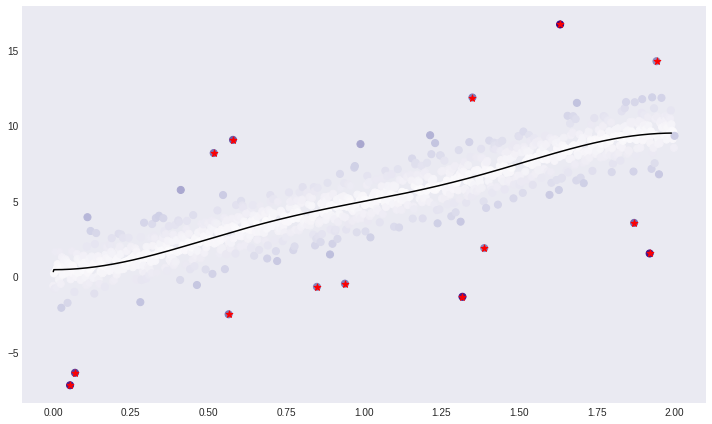

In [53]:
_simul.fit(sd=5,ref=20,ymin=-10,ymax=15)

## Linear(2)

In [54]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [55]:
df2=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [56]:
_simul2 = SIMUL(df2)

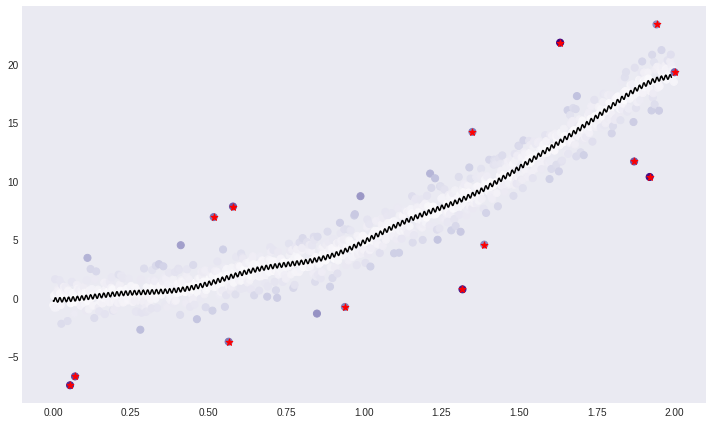

In [57]:
_simul2.fit(sd=5,ref=20,ymin=-10,ymax=15)

## COS

In [58]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [59]:
df4=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [60]:
_simul4 = SIMUL(df4)

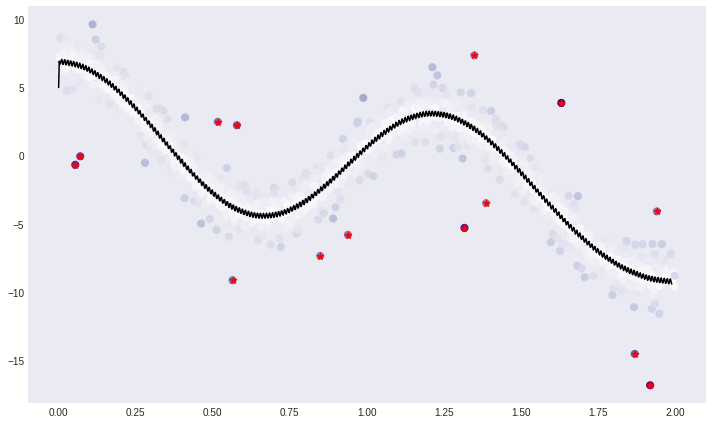

In [61]:
_simul4.fit(sd=5,ref=20,ymin=-10,ymax=15)

## SIN

In [62]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [63]:
df5=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [65]:
_simul5 = SIMUL(df5)

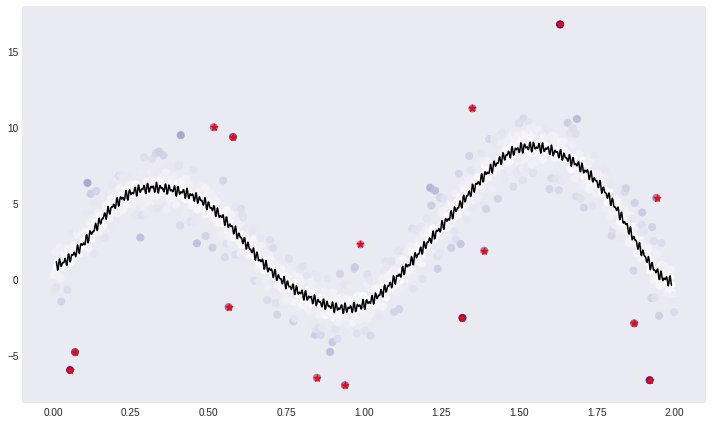

In [66]:
_simul5.fit(ref=15,ymin=-10,ymax=15,cuts=5)

## 1D manifold

In [69]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

In [70]:
df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f, 'f1' : f1})

In [147]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.f1 = df.f1.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=60): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.dif=(np.abs(self.f-self.fhat)-np.min(np.abs(self.f-self.fhat)))/(np.max(np.abs(self.f-self.fhat))-np.min(np.abs(self.f-self.fhat)))
        self.df = self.df.assign(dif = self.dif)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05
        p = plt.figure(figsize=(12,12))
        ax = p.add_subplot(1,1,1, projection='3d')
        ax.grid(False)
        ax.scatter3D(self.x,self.y,self.f,c=self.dif,cmap='winter',zdir='z',s=50,marker='.',alpha=0.2)
        ax.scatter3D(self.x,self.y,self.fhat,color='black',zdir='z',s=50,marker='.',alpha=0.2)
        ax.scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['f'],color='red',zdir='z',s=100,marker='.',alpha=1)
        ax.plot3D(self.x,self.y,self.f1,'black')
        ax.plot3D(self.x,self.y,[0]*1000,'black')
        ax.set_xlim(-3,3)
        ax.set_ylim(-3,3)
        ax.set_zlim(-15,15)
        ax.view_init(elev=20., azim=40)

In [148]:
_simul3d = SIMUL(df)

In [149]:
_simul3d.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 523.85it/s]


In [150]:
_simul3d.get_weightmatrix(theta=(_simul3d.D[_simul3d.D>0].mean()),kappa=2500) 

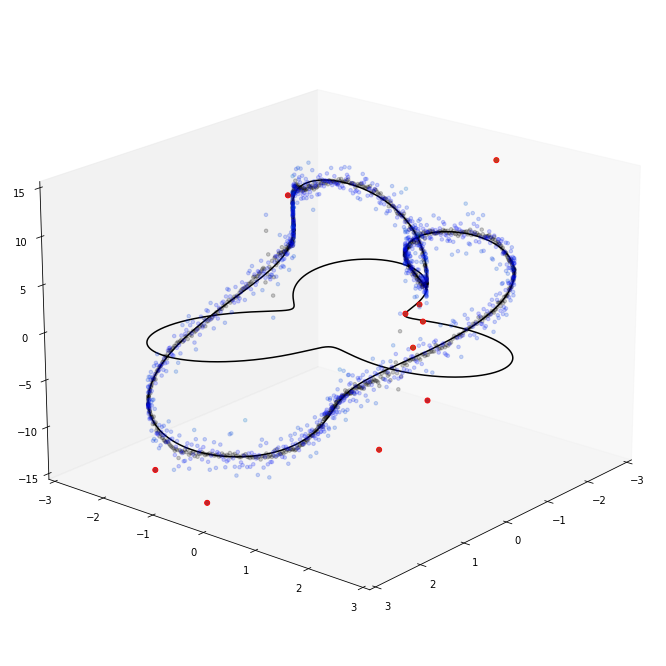

In [151]:
_simul3d.fit(sd=5,ref=20)

## Bunny

In [154]:
G = graphs.Bunny()
n = G.N

In [155]:
g = filters.Heat(G, tau=75) # 꼬리부분의 빨간신호를 퍼지게하는 정도

In [157]:
normal = np.random.randn(n)*0.3
unif = np.concatenate([np.random.rand(63)*3, np.zeros(n-63)]); np.random.shuffle(unif)
noise = normal + unif

In [158]:
f = np.zeros(n)
f[1000] = 3234
f = g.filter(f, method='chebyshev') 

2022-11-06 09:16:00,629:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [160]:
W = G.W.toarray()
x = G.coords[:,0]
y = G.coords[:,1]
z = -G.coords[:,2]

In [161]:
df = pd.DataFrame({'x' : x, 'y' : y, 'z' : z, 'f' : f, 'noise' : noise})

In [174]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05
        
        p = plt.figure(figsize=(12,12))
        ax = p.add_subplot(1,1,1, projection='3d')
        ax.grid(False)
        ax.scatter3D(self.x,self.y,self.z,c=self.fnoise,cmap='jet',zdir='z',s=abs(self.fnoise)*100,marker='.',alpha=0.2)
        ax.scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['z'],zdir='z',s=abs(self.df.query('Residual**2>@ref')['fnoise'])*50,marker='.',alpha=1)
        ax.view_init(elev=60., azim=-90)

In [175]:
_simul = SIMUL(df)

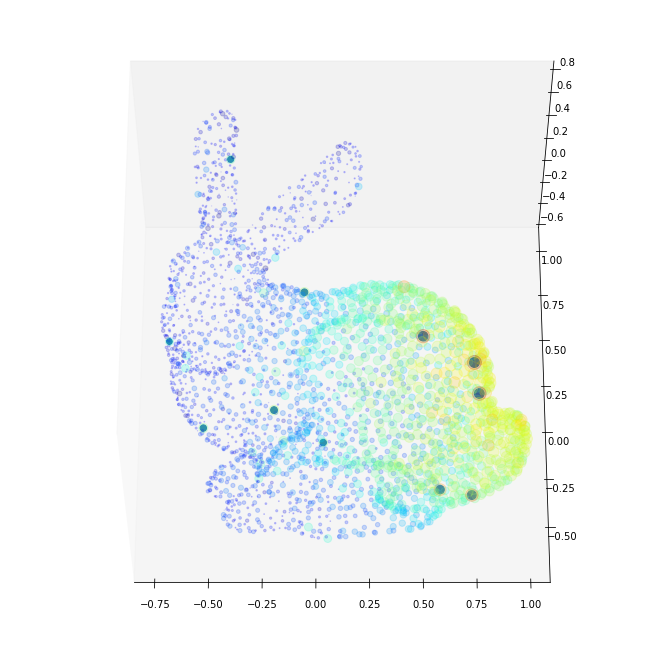

In [176]:
_simul.fit()

## Earthquake

In [177]:
df= pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

In [178]:
df_global= pd.concat([pd.read_csv('00_05.csv'),pd.read_csv('05_10.csv'),pd.read_csv('10_15.csv'),pd.read_csv('15_20.csv')]).iloc[:,[0,1,2,4]].rename(columns={'latitude':'Latitude','longitude':'Longitude','mag':'Magnitude'}).reset_index().iloc[:,1:]

In [179]:
df_global = df_global.assign(Year=list(map(lambda x: x.split('-')[0], df_global.time))).iloc[:,1:]

In [186]:
df_global.Year = df_global.Year.astype(np.float64)

In [187]:
class MooYaHo:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')

In [188]:
class MooYaHo2(MooYaHo): # ebayesthresh 기능추가
    def fit2(self,ref=0.5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2)))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        self.con = np.where(self.df.Residual>0.7,1,0)

In [189]:
class eachlocation(MooYaHo2):
    def haiti(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=5,
                        center=dict(lat=18.4430, lon=-72.5710), 
                        zoom=5,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'red',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 20,
                      marker_color= 'blue',
                      opacity = 1
                      )
        fig.show()
    def lquique(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=5,
                        center=dict(lat=-32.6953, lon=-71.4416), 
                        zoom=5,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'red',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 20,
                      marker_color= 'blue',
                      opacity = 1
                      )
        fig.show()        
    def sichuan(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=3,
                        center=dict(lat=30.3080, lon=102.8880), 
                        zoom=5,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'red',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 20,
                      marker_color= 'blue',
                      opacity = 1
                      )
        fig.show()

In [190]:
each_location=eachlocation(df_global.query("2010 <= Year < 2015"))

`-` get distance 

In [191]:
each_location.get_distance()

100%|██████████| 12498/12498 [03:16<00:00, 63.45it/s]  


In [192]:
each_location.D[each_location.D>0].mean()

8810.865423093777

(array([14176290., 16005894., 21186674., 22331128., 19394182., 17548252.,
        16668048., 13316436., 12973260.,  2582550.]),
 array([8.97930163e-02, 2.00141141e+03, 4.00273303e+03, 6.00405465e+03,
        8.00537626e+03, 1.00066979e+04, 1.20080195e+04, 1.40093411e+04,
        1.60106627e+04, 1.80119844e+04, 2.00133060e+04]),
 <BarContainer object of 10 artists>)

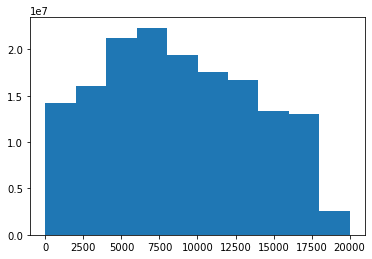

In [193]:
plt.hist(each_location.D[each_location.D>0])

`-` weight matrix

In [194]:
each_location.get_weightmatrix(theta=(8810.865423093777),kappa=2500) 

`-` fit

In [195]:
each_location.fit2()

In [ ]:
each_location.haiti(MagThresh=6.9,ResThresh=0.5)

In [ ]:
each_location.lquique(MagThresh=6.4,ResThresh=0.4)

In [ ]:
each_location.sichuan(MagThresh=6.5,ResThresh=0.4)